### Habib Shirzad

### dataset link: https://www.kaggle.com/datasets/joebeachcapital/restaurant-reviews/data 

### Introduction:
this dataset contains 10000 reviews, it includes 8 columns and 10000 thousands rows. using this dataset we are going to create pipline which includes 3 different models. first of all we are going to clean and preprocess our data, convert it to numerical values and then split it. after trying 3 different models we are going to choose the best model with the highest accuracy. 

### problem statement

the purpose of this project is to build a text classificaton model to categorize user reviews whether its negative
or positive. we are going to use NLP text classification methods to find out the numbers of words, sentences, characters
,and also create a new column using our existing data to find out if a feedback is negative or positive then store
it in a new column called liked. and after converting the dataset into numeric we will apply the models and choose 
the best one based on their performance.

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import warnings, nltk, re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
warnings.filterwarnings('ignore')

### loading dataset

In [3]:
df = pd.read_csv('Res.csv')
df.tail(5)

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
9995,Chinese Pavilion,Abhishek Mahajan,Madhumathi Mahajan Well to start with nice cou...,3,"53 Reviews , 54 Followers",6/5/2016 0:08,0,NaN
9996,Chinese Pavilion,Sharad Agrawal,This place has never disappointed us.. The foo...,4.5,"2 Reviews , 53 Followers",6/4/2016 22:01,0,NaN
9997,Chinese Pavilion,Ramandeep,"Bad rating is mainly because of ""Chicken Bone ...",1.5,"65 Reviews , 423 Followers",6/3/2016 10:37,3,NaN
9998,Chinese Pavilion,Nayana Shanbhag,I personally love and prefer Chinese Food. Had...,4,"13 Reviews , 144 Followers",5/31/2016 17:22,0,NaN
9999,Chinese Pavilion,Bhargava Krishna,Checked in here to try some delicious chinese ...,3.5,"472 Reviews , 1302 Followers",5/31/2016 16:41,6,NaN


Below we are going to drop the the columns that we dont need using pandas drop method.

### Understanding and cleaning our dataset

In [4]:
df = df.drop(['Reviewer','Restaurant','Rating','Metadata','Time','Pictures','7514'],axis=1)
df.tail(5)

,Review
9995,Madhumathi Mahajan Well to start with nice cou...
9996,This place has never disappointed us.. The foo...
9997,"Bad rating is mainly because of ""Chicken Bone ..."
9998,I personally love and prefer Chinese Food. Had...
9999,Checked in here to try some delicious chinese ...


In [5]:
df['Review'][1]

'Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service'

we are adding a new column called Liked, in this column we will have two values 0 or 1. if a review is 
possitive then its value should be 1 or if its negative then it should be 0. to do that we need to create 
a function called chck. we have a list of keywords which we will loop through them, and if a sentence has any of 
the keywords that means it is a negative comment.

In [6]:
def chck(sent):
    if isinstance(sent,str):
        keywords = ['not','nobody', 'cannot', "couldn't", "can't", "shouldn't", "shouldn't've", "won't", "wouldn't", "wouldn't've", "isn't", "aren't",  "wasn't", "weren't", "haven't", "hasn't", "hadn't", "don't", "doesn't", "didn't", "wont", "wouldn't"]
        for key in keywords:
            if key in sent:
                return 0
    return 1

df['liked'] = df['Review'].apply(chck)
df.tail(3)

,Review,liked
9997,"Bad rating is mainly because of ""Chicken Bone ...",0
9998,I personally love and prefer Chinese Food. Had...,0
9999,Checked in here to try some delicious chinese ...,0


To double check if we havent lost any data we are going to use the value counts method to see the number of 
possitive and negative comments in the Liked column. as you can below we have the 6805 possitive and 3195 negative
review which in total will be 10000 means we havent lost any data.

In [7]:
df['liked'].value_counts()[1]

6805

In [8]:
df['liked'].value_counts()[0]

3195

In [9]:
df['Review'] = df['Review'].astype(str)

Below we are going to make sure our review has only string datatypes and then we are creating a new column and
count the number characters and then using lambda function we create another column called word count. after that 
using sentence tokenizer we are adding a new column to our dataset to count the number of sentences in every review.

In [10]:
df['char_cnt'] = df['Review'].apply(len)
df.tail(3)

,Review,liked,char_cnt
9997,"Bad rating is mainly because of ""Chicken Bone ...",0,1555
9998,I personally love and prefer Chinese Food. Had...,0,511
9999,Checked in here to try some delicious chinese ...,0,517


### Tokenizing words and sentences

In [11]:
df['word_cnt'] = df['Review'].apply(lambda x : len(nltk.word_tokenize(str(x))))
df.tail(3)

,Review,liked,char_cnt,word_cnt
9997,"Bad rating is mainly because of ""Chicken Bone ...",0,1555,315
9998,I personally love and prefer Chinese Food. Had...,0,511,96
9999,Checked in here to try some delicious chinese ...,0,517,103


In [12]:
df['sent_cnt'] = df['Review'].apply(lambda x : len(nltk.sent_tokenize(str(x))))
df.tail(3)

,Review,liked,char_cnt,word_cnt,sent_cnt
9997,"Bad rating is mainly because of ""Chicken Bone ...",0,1555,315,10
9998,I personally love and prefer Chinese Food. Had...,0,511,96,7
9999,Checked in here to try some delicious chinese ...,0,517,103,6


### Removing stopwords from our data
we have done a little bit of data preprocessing in the columns above, but we are going to do the important things
here. for example first of all we need to download the punkt and stopwords and the create a custom stopwords to
avoid affecting our models accuracy. for example if we have a sentence pizza not good. if we apply the stopwords it will change the sentence to pizza good since not is in the stopwords. so to avoid that we are going to create a custom stopwords and then remove them from the original stopwords. also we apply the regular expression to have only alphabets in our sentences and stemmer to keep only the stem of words. and then we join the remainings and 
append them to our lsit which is called corpus.

In [13]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/habibshirzad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/habibshirzad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
custom_stopwords = {'don', "don't", 'should', "should've", 'now','ain','no', 'nor', 'not',
                    'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",
                    'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', 
                    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
                    'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"}


corpus = []
ps = PorterStemmer()

stop_words = set(stopwords.words('english')) - custom_stopwords

for i in range(len(df)):
    revu = re.sub('[^a-zA-Z]',' ',df['Review'][i]).lower()
    revu = revu.split()
    revu = [ps.stem(word) for word in revu if word not in stop_words]
    revu = " ".join(revu)
    corpus.append(revu)

Creating a new column called processed text and then we are droping the Review column since we dont need it anymore



In [15]:
df['processed_text'] = corpus
df.tail(3)

,Review,liked,char_cnt,word_cnt,sent_cnt,processed_text
9997,"Bad rating is mainly because of ""Chicken Bone ...",0,1555,315,10,bad rate mainli chicken bone found veg food no...
9998,I personally love and prefer Chinese Food. Had...,0,511,96,7,person love prefer chines food coupl time husb...
9999,Checked in here to try some delicious chinese ...,0,517,103,6,check tri delici chines food seen non veg lunc...


### Comparing 
Comparing the two processed and original review after applying the tokenization. we can see that our processed 
text is a lot more cleaner and less than the original one.

In [16]:
df['processed_text'][1]

'ambienc good pleasant even servic prompt food good good experi soumen da kudo servic'

In [17]:
df['Review'][1]

'Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service'

In [18]:
df = df.drop('Review',axis=1)

In [19]:
df.tail(7)

,liked,char_cnt,word_cnt,sent_cnt,processed_text
9993,0,296,63,6,im go cut chase food excel must say honey chic...
9994,0,939,192,12,chines pavilion banjara hill first chines rest...
9995,0,1024,218,13,madhumathi mahajan well start nice courteou se...
9996,1,320,61,5,place never disappoint us food courteou staff ...
9997,0,1555,315,10,bad rate mainli chicken bone found veg food no...
9998,0,511,96,7,person love prefer chines food coupl time husb...
9999,0,517,103,6,check tri delici chines food seen non veg lunc...


### Visualizing our data
using word cloud we can easily see how the most frequent words in the positive and negative reviews.

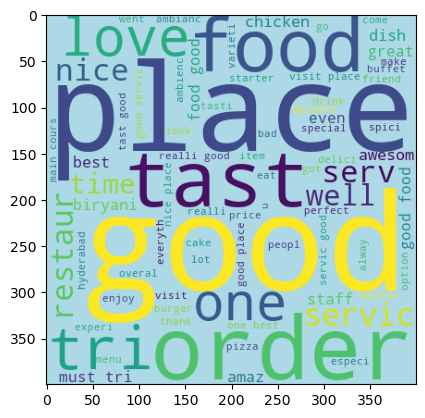

In [20]:
wc = WordCloud(width=400,height=400,min_font_size=11,background_color='lightblue')
pos_rev = wc.generate(df[df['liked']==1]['processed_text'].str.cat(sep=" "))
plt.imshow(pos_rev)

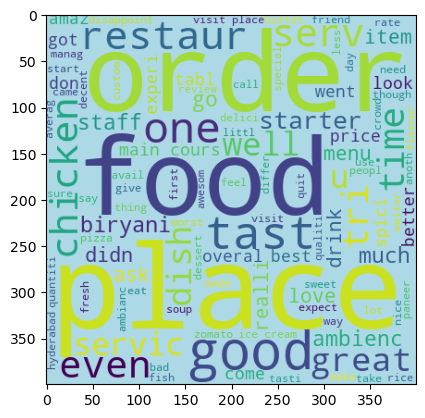

In [21]:
neg_rev = wc.generate(df[df['liked']==0]['processed_text'].str.cat(sep=" "))
plt.imshow(neg_rev)

### Vectorizing and splitting our data
now that our dataset is ready, in order to build a pipeline we need to convert our dataset to numeric. to do that 
we use count vectorizer. in simple words count vectorizer covnert text into numerical values.

In [22]:
cv = CountVectorizer(max_features=2000)
x = cv.fit_transform(corpus).toarray()
y = df['liked']

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

### First Model - Naive bayes
we are using naive bayes because of its simplicity and efficiency and also it has the ability to takecare of data with high dimensions. 

In [24]:
NB = GaussianNB()
NB.fit(x_train,y_train)
y_pred = NB.predict(x_test)
accuracy_score(y_test,y_pred)

0.717

### Second Model - Logistic Regression

In [25]:
LogR = LogisticRegression()
LogR.fit(x_train,y_train)
y_pred = LogR.predict(x_test)
accuracy_score(y_test,y_pred)

0.9325

### Third Model - Random Forest Classifier 

In [26]:
RndmFC = RandomForestClassifier()
RndmFC.fit(x_train,y_train)
y_pred = RndmFC.predict(x_test)
accuracy_score(y_test,y_pred)

0.939

### Conclusion:
as we can see above the best model for our text classification is Random Forest Classifier with 94% accurate classification. we can take the model to next step by applying and adding new parameters and features to improve our model's accuracy to a higher level. 
Overall, our dataset contains 10000 of reviews. we used the review column and added new columns for example
liked, word count, sent count, character count and proccessed text. processed text column is the new version of 
our Review column which we used NLP and pandas methods to clean the text and remove stopwords and left stem of the words. after that we removed all the unnecessary columns and made sure that all our data is numerical. after visualizing the most frequent words we took it to the next level by building models. we used three models
but as you can see above the best model for our classification here is Naive Bayes. the future work could be to add 
some new feature and paramters to increase the accuracy even higher.